In [29]:
using CSV, DataFrames
df = CSV.read("../data/race_dataset.csv", DataFrame)

Row,box,odds,slit_score,horse
,Int64,Float64,Float64,String31
1,2,4.7,1.0,ブラウンラチェット
2,1,15.6,0.15627,ミストレス
3,8,4.1,0.15627,ショウナンザナドゥ
4,4,6.6,0.0624745,シホリーン
5,3,6.3,0.0390184,マイエレメント
6,10,3.1,0.023662,カムニャック
7,6,57.9,0.00390625,マピュース
8,11,79.9,5.42129e-5,クレオズニードル
9,5,13.4,6.45949e-8,ミリオンローズ


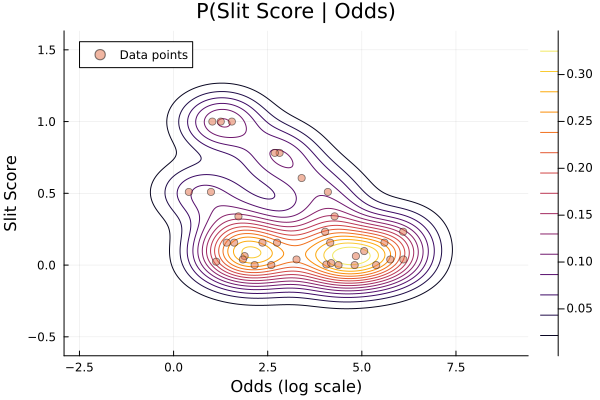

In [30]:
using KernelDensity, StatsPlots

# データの準備
odds = df.odds
slit_score = df.slit_score

# 2次元KDEの計算
kde_obj = kde((log.(odds), slit_score))  # オッズは対数スケールで扱う

# 条件付き確率密度関数の計算と可視化
p = plot(xlabel="Odds (log scale)", ylabel="Slit Score", title="P(Slit Score | Odds)")
contour!(p, kde_obj.x, kde_obj.y, kde_obj.density')
scatter!(p, log.(odds), slit_score, alpha=0.5, label="Data points")


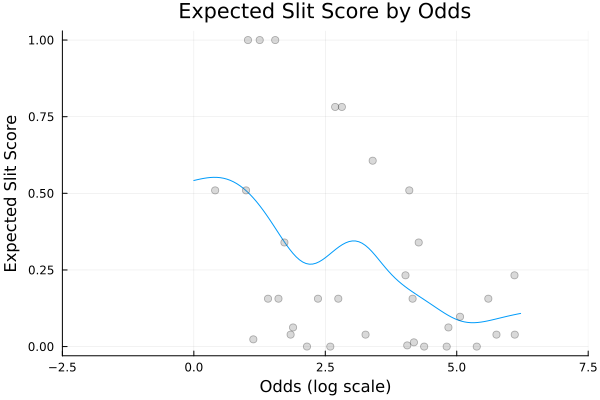

In [31]:
using Statistics
using Plots

# 特定のoddsにおけるslit_scoreの条件付き期待値を計算する関数
function conditional_mean(odds_point, df, bandwidth=0.5)
    weights = exp.(-(log.(df.odds) .- log(odds_point)).^2 ./ (2 * bandwidth^2))
    return sum(weights .* df.slit_score) / sum(weights)
end

# オッズの範囲でグリッドを作成
odds_grid = exp.(range(log(1.0), log(500), length=100))

# 各オッズポイントでの条件付き期待値を計算
mean_slit_scores = [conditional_mean(o, df) for o in odds_grid]

p = plot(log.(odds_grid), mean_slit_scores, 
    xlabel="Odds (log scale)", 
    ylabel="Expected Slit Score",
    xlim=(-2.5, 7.5),
    legend=false,
    title="Expected Slit Score by Odds")

# 実データ点も同じスケールで表示
scatter!(log.(df.odds), df.slit_score, alpha=0.3, color=:gray)

# x軸のティックを実数表示に変更
xticks!(-2.5:2.5:7.5)  # 等高線グラフと同じ実数表示

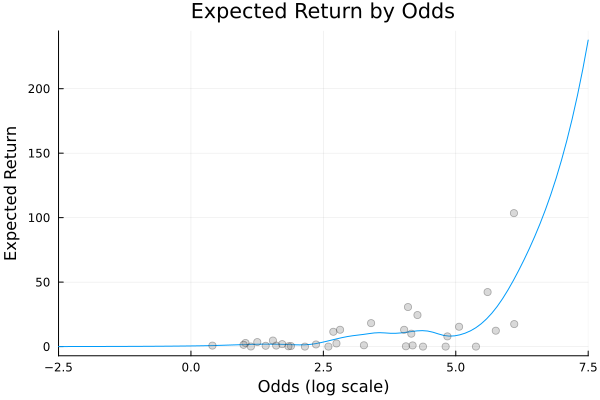

In [32]:
# 期待収益（Expected Return）を計算する関数
function expected_return(odds_point, df, bandwidth=0.3)
    weights = exp.(-(log.(df.odds) .- log(odds_point)).^2 ./ (2 * bandwidth^2))
    expected_slit = sum(weights .* df.slit_score) / sum(weights)
    return expected_slit * odds_point  # オッズを実数値で掛け算
end

# オッズの範囲でグリッドを作成（実数値）
odds_grid = exp.(range(-2.5, 7.5, length=100))

# 各オッズポイントでの期待収益を計算
expected_returns = [expected_return(o, df) for o in odds_grid]

# プロット
p = plot(log.(odds_grid), expected_returns, 
    xlabel="Odds (log scale)", 
    ylabel="Expected Return",
    xlim=(-2.5, 7.5),
    legend=false,
    title="Expected Return by Odds")

# 実データ点も表示（各馬の実際の期待収益）
scatter!(log.(df.odds), df.slit_score .* df.odds, alpha=0.3, color=:gray)

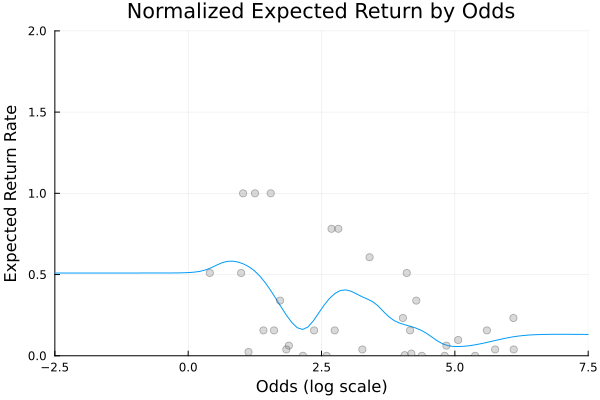

In [33]:
# バンド幅を調整してより局所的な特徴を捉える
function normalized_expected_return(odds_point, df, bandwidth=0.3)  # バンド幅を小さく
    weights = exp.(-(log.(df.odds) .- log(odds_point)).^2 ./ (2 * bandwidth^2))
    expected_slit = sum(weights .* df.slit_score) / sum(weights)
    return expected_slit  # 収益率として表現
end

# プロット更新
p = plot(log.(odds_grid), [normalized_expected_return(o, df) for o in odds_grid], 
    xlabel="Odds (log scale)", 
    ylabel="Expected Return Rate",  # 収益率として表示
    xlim=(-2.5, 7.5),
    ylim=(0, 2),  # 適切な範囲に制限
    legend=false,
    title="Normalized Expected Return by Odds")

# 実データ点も正規化して表示
scatter!(log.(df.odds), df.slit_score, alpha=0.3, color=:gray)

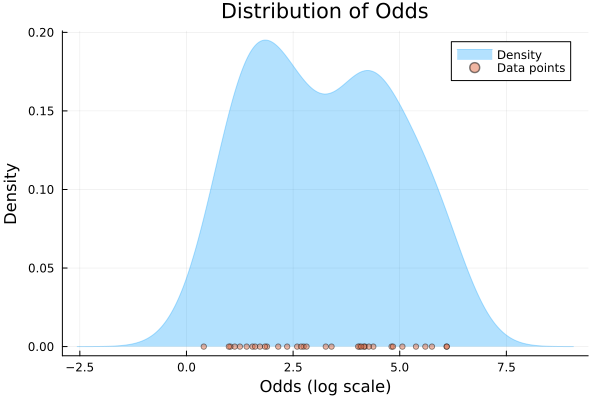

In [34]:
using KernelDensity
using Plots

# 例：オッズの分布を見る
odds = df.odds

# 1次元KDEの計算
kde_odds = kde(log.(odds))  # 対数スケールで計算

# プロット
plot(kde_odds.x, kde_odds.density,
    xlabel="Odds (log scale)",
    ylabel="Density",
    title="Distribution of Odds",
    label="Density",
    fill=true, alpha=0.3)

# 実データポイントも表示
scatter!(log.(odds), zeros(length(odds)), 
    label="Data points",
    alpha=0.5,
    markersize=3)

In [36]:
using MLJ

# 簡単な例
function naive_bayes_example()
    # サンプルデータ
    X = DataFrame(
        odds = [2.0, 3.0, 15.0, 20.0],
        box = [1, 8, 3, 6],
        running_style = ["front", "stalker", "front", "closer"]
    )
    y = [1, 1, 0, 0]  # 1: 勝利, 0: 敗北

    # モデルの作成と学習
    model = CategoricalNB()  # カテゴリカルな特徴量用
    mach = machine(model, X, y)
    fit!(mach)

    # 新しいデータでの予測
    new_horse = DataFrame(
        odds = [5.0],
        box = [2],
        running_style = ["stalker"]
    )
    predict_proba(mach, new_horse)
end

┌ Warning: Module ColorTypes with build ID fafbfcfd-e5d4-1818-0000-09ad483d9845 is missing from the cache.
│ This may mean ColorTypes [3da002f7-5984-5a60-b8a6-cbb66c0b333f] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:2541
┌ Warning: Module ColorTypes with build ID fafbfcfd-e5d4-1818-0000-09ad483d9845 is missing from the cache.
│ This may mean ColorTypes [3da002f7-5984-5a60-b8a6-cbb66c0b333f] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:2541
┌ Warning: Module ColorTypes with build ID fafbfcfd-e5d4-1818-0000-09ad483d9845 is missing from the cache.
│ This may mean ColorTypes [3da002f7-5984-5a60-b8a6-cbb66c0b333f] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:2541
┌ Warning: Module ScientificTypes with build ID ffffffff-ffff-ffff-0000-15d19d5bbf18 is missing from the cache.
│ This may mean ScientificTypes [321657f4-b219-11e9-178b-2701a2544e81] does not s

naive_bayes_example (generic function with 1 method)